# MATLAB tools for VEM in 3D

In the following, __VEM_ROOTDIR__ refers to the directory in which the VEM code lies.

## Geometric structures

A polyhedral mesh is represented using a data structure borrowed from https://www.openvolumemesh.org. In this data structure, which will be called the __OVM format__, cells (element), faces, edges are represented using lists of handles to the corresponding incident entities. Such handles uniquely identify each geometric object and its orientation.

A pair of oppositely oriented half-faces is associated with each face. Each half-face is uniquely identified by a handle. Similarly, each edge is split into a pair of oppositely oriented half-edges, identified by their corresponding handle.

With the help of such handles, each entity of dimension d as well as its orientation is defined by a list of handles to its incident entities of dimension d-1. In particular:

- a cell is uniquely identified by a lists of half faces which are oriented counterclockwise with respect to the outward normal;
- a half face is uniquely identified by a list of half edges whose union must form a closed, connected, and consistently oriented 1-manifold;
- a half edge is defined by an ordered list of handles to its incident vertices.

By construction, all opposing half-entities have consecutive indices. Thanks to this choice, we can physically store just one of the two half-entities and defined the opposite one by the inverse list of incident lower dimensional entities. For example, let $N_\text{fc}$ be total number of physical faces of a polyhedral mesh, and $h$ be a half face handle, with $h \in \{1, \dots, 2N_\text{fc}\}$. Then, access to the half face $h$ is done via the following mapping:

$$\text{half face}(h) = \begin{cases}\text{face2hedges}\Bigl[\frac{h+1}{2}\Bigr] & \text{if }h\text{ is odd}\\\text{opp}\Bigl( \text{face2hedges}\Bigl[\frac{h}{2}\Bigr]\Bigr) & \text{if }h\text{ is even}\end{cases}$$,

where face2hedges is the cell array in which the half faces objects are stored, and face2hedges$[i]$, with $1 \leq i\leq N_\text{fc}$, evaluates to the half face object stored at position $i$ of the array.

Thus, we are storing the following top-down incident relationships (and orientations):

C(ells) -> F(aces) -> E(dges) -> V(ertices).

Additionally, in view of future VEM implementations in HDG style, we also store the (bottom up) connectivity information from each face to its neighboring elements:

F -> C.

In the next paragraph, some examples of meshes in OVM format are provided.

### One polyhedron meshes

The script __VEM_ROOTDIR/Mesh_Handlers/meshfiles3d/one_polyhedron/geom3dexamples.m__ generates and saves few OVM meshes representing different polyhedra:

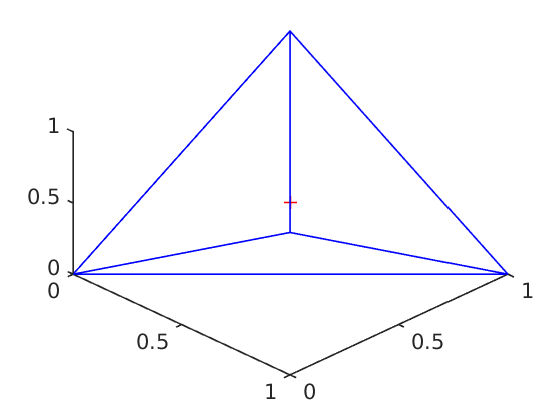

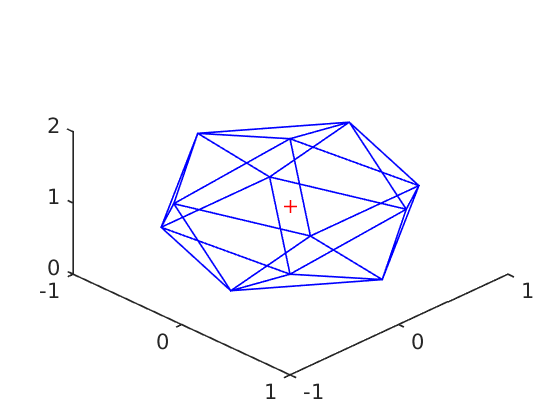

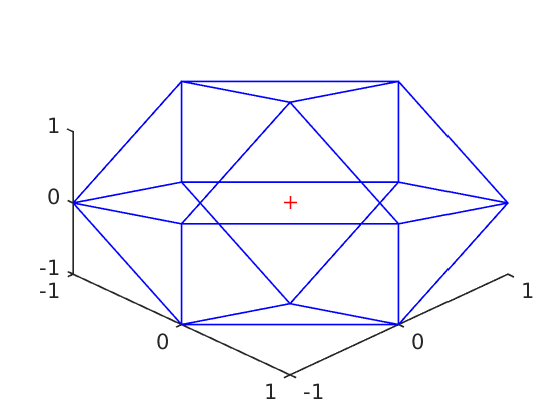

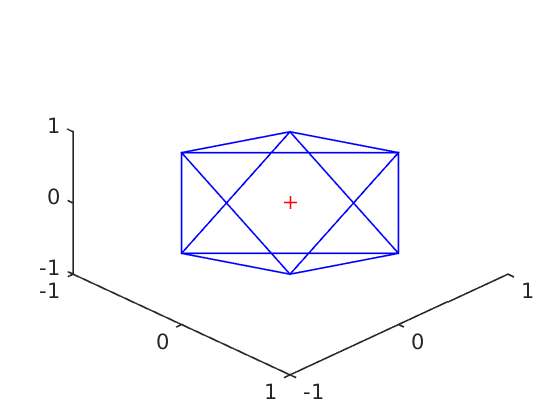

In [1]:
cd ../Mesh_Handlers/meshfiles3d/one_polyhedron/
geom3dexamples

All the meshes have been generated with the script __VEM_ROOTDIR/Mesh_Handlers/drawOVMmesh.m__.

Let us have a closer look at the mesh cube.mat, which represents the unit cube $[0,1] \times [0,1] \times [0,1]$.

In [2]:
load cube.mat
mesh

mesh = 

              Nelt: 1
       coordinates: [8x3 double]
              Nver: 8
     edge2vertices: [12x2 double]
               Ned: 12
               Nfc: 6
     face2elements: [6x2 double]
    element2hfaces: {[1 3 5 7 9 11]}
       face2hedges: {6x1 cell}


The mesh object contains the following fields:

- $\verb|Nelt|, \verb|Nfc|, \verb|Ned|, \verb|Nver|$: the number of (physical) elements, faces, edges, and vertices, respectively.
- $\verb|element2hfaces|$: a $1\times 1$ __cell array__ representing the unit cube. $\verb|element2faces|\{1\}$ is an array whose entries represent the incident half faces, oriented counterclockwise with respect to the outward normal.
- $\verb|face2hedges|$: a $\verb|Nfc|\times 1$ __cell array__ where the half faces are physically stored. Its $f$th entry $\verb|face2hedges{f}|$ is an array containing the incident half edges, specified in an order such that their union forms a closed, connected, and consistently oriented $1$-manifold.
- $\verb|edge2vertices|$: a $\verb|Ned|\times 2$ __array__, whose $e$th row represents a half edge. $\verb|edge2vertices(e,:)|$ contains the indices of the incident vertices.
- $\verb|coordinates|$: a $\verb|Nver|\times 3$ __array__ with the coordinates of the vertices.
- $\verb|face2elements|$: a $\verb|Nfc|\times 2$ __array__, whose $f$th row $\verb|face2elements(f,:)|$ contains the IDs of the two incident elements. If $f$ is a boundary face, there is only one incident element, which is contained in $\verb|face2elements(f,1)|$. In this case, we set $\verb|face2elements(f,2)| = -1$.

The folder one_polyhedron also contains more complex polyhedra:

- a single Voronoi cell: single_cell.mat;

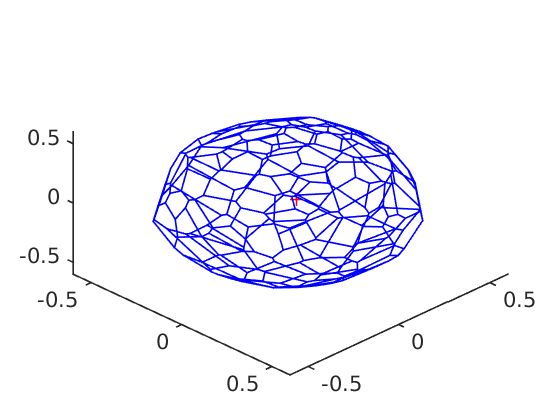

In [3]:
load single_cell
drawOVMmesh
view(45,45); xlim([-0.6,0.6]); ylim([-0.6,0.6]); zlim([-0.6,0.6])

- examples of degenerate Voronoi cells: degenerate1.mat, degenerate2.mat, degenerate3.mat.

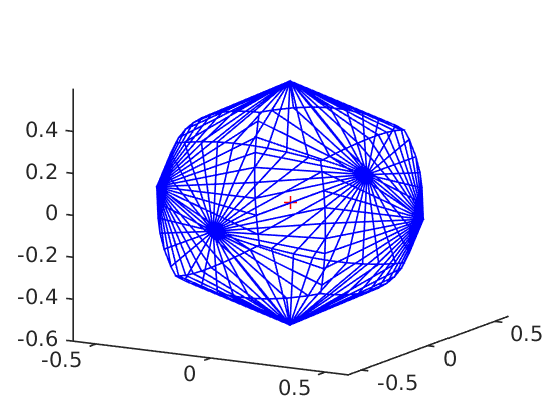

In [4]:
load degenerate1
drawOVMmesh
view(30,15); xlim([-0.6,0.6]); ylim([-0.6,0.6]); zlim([-0.6,0.6]);

In [5]:
load degenerate2
drawOVMmesh
view(20,15); xlim([-0.6,0.6]); ylim([-0.6,0.6]); zlim([-0.6,0.6]);

In [6]:
load degenerate3
drawOVMmesh
view(20,15); xlim([-0.6,0.6]); ylim([-0.6,0.6]); zlim([-0.6,0.6]);

All the Voronoi cells have been generated with the [Voro++ library](http://math.lbl.gov/voro++/) and then converted to the OVM mesh format with the function __VEM_ROOTDIR/Mesh_Handlers/meshfiles3d/one_polyhedron/voroppcell2ovm.m__.

### Tetrahedral meshes

The folder ../Mesh_Handlers/meshfiles3d/tetrahedra contains a coarse partition of the unit cube into 6 tetrahedra (tetra_Nelt000006.mat) and 6 __nested__ refinements. These meshes have been generated with the script __VEM_ROOTDIR/Mesh_Handlers/create_tetramesh.m__.

As an example, let us plot the mesh tetra_Nelt000384.mat:

In [7]:
cd ../tetrahedra/
load tetra_Nelt000384
drawOVMmesh
view(30,15); xlim([0,1]); ylim([0,1]); zlim([0,1]);

### Hexahedral meshes

The folder __VEM_ROOTDIR/Mesh_Handlers/meshfiles3d/hexahedra__ contains two types of hexahedral meshes:

- cubes_Nelt*.mat: __nested__ partitions of the unit cube into regular hexahedra, i.e. cubes;
- hexa_Nelt*.mat: __nested__ partitions of the unit cube into non regular hexahedra.

As an example, let us plot the meshes cubes_Nelt000064.mat and hexa_Nelt000064.mat:

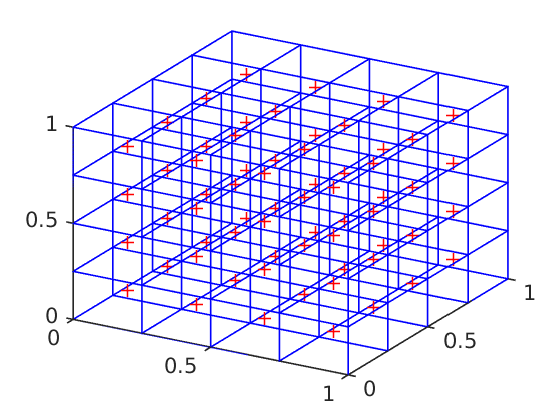

In [8]:
cd ../hexahedra/
load cubes_Nelt000064
drawOVMmesh
view(30,30); xlim([0,1]); ylim([0,1]); zlim([0,1]);

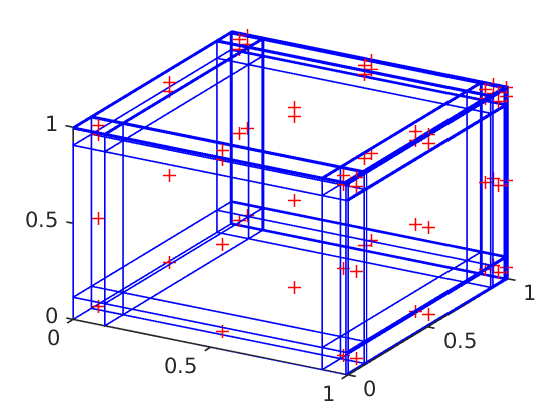

In [9]:
load hexa_Nelt000064
drawOVMmesh
view(30,30); xlim([0,1]); ylim([0,1]); zlim([0,1]);

These meshes have been created with the script __VEM_ROOTDIR/Mesh_Handlers/create_hexamesh.m__ and the function __VEM_ROOTDIR/Mesh_Handlers/random_refine.m__.

### Voronoi meshes

The folder ../Mesh_Handlers/meshfiles3d/voronoi contains some examples of Voronoi meshes:

- cube/cube_Nelt*.mat: Voronoi tessellations in the cube $[-a,a]\times[-a,a]\times[-a,a]$, with $a = 1.1$. These meshes have been generated as duals of __nested__ Delaunay triangulations of $[-1,1]\times[-1,1]\times[-1,1]$. In particular, they have been generated as follows:

    - Generate a Delaunay tetrahedral mesh of the cube $[-1,1]\times[-1,1]\times[-1,1]$ using [gmsh](http://gmsh.info/).
    - Extract the nodes of the mesh with MATLAB.
    - Provide these nodes as input particles to Voro++ to generate dual Voronoi meshes. In order to avoid degenerate Voronoi cells, Delaunay nodes are encapsulated into a bigger cube, i.e. $[-1.1,1.1]\times[-1.1,1.1]\times[-1.1,1.1]$. This implies that Voronoi cells on the domain boundary do not necessarily scale as Voronoi cells inside the domain, thus __affecting the behavior of the maximum mesh diameter__.
    - Convert the output of Voro++ into the OVM mesh format using __VEM_ROOTDIR/Mesh_Handlers/voroppmesh2ovm.m__.
    
    
- cube/unitcube_voro_Nelt*.mat: Voronoi tessellations for random points inserted in the cube $[0,1]\times[0,1]\times[0,1]$. Every mesh has been created with Voro++ by adding new random points to the previously generated mesh and then converted into OVM format with VEM_ROOTDIR/Mesh_Handlers/voroppmesh2ovm.m.

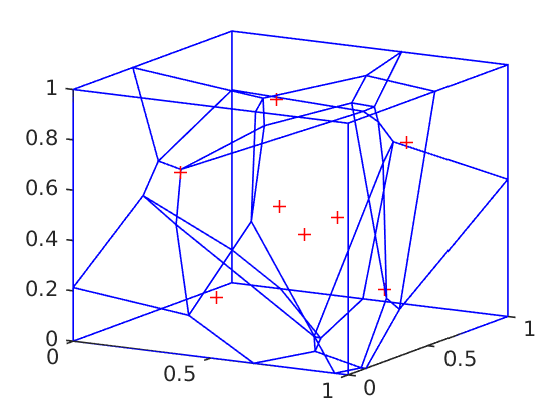

In [10]:
cd ../voronoi/cube/
addpath '../../../'
load unitcube_voro_Nelt8
drawOVMmesh
view(30,15); xlim([0,1]); ylim([0,1]); zlim([0,1]);

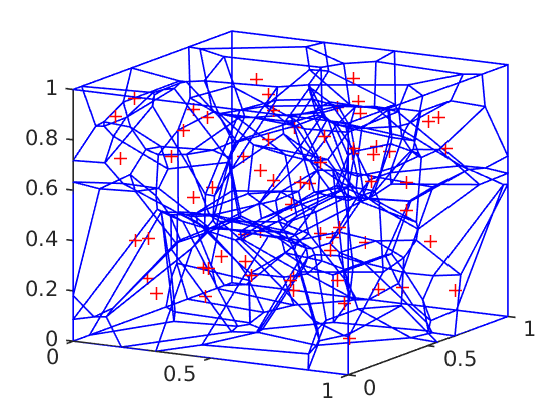

In [11]:
load unitcube_voro_Nelt64
drawOVMmesh
view(30,15); xlim([0,1]); ylim([0,1]); zlim([0,1]);

In [12]:
load cube_Nelt512
drawOVMmesh
view(30,15); xlim([0,1]); ylim([0,1]); zlim([0,1]);

Unable to read file 'cube_Nelt512'. No such file or directory.


Same Voronoi meshes as before (plus two finer Voronoi meshes) visualized with [POVRAY](http://www.povray.org/).
![title](img/unitcube_voro_Nelt8.png)
![title](img/unitcube_voro_Nelt64.png)
![title](img/unitcube_voro_Nelt512.png)
![title](img/unitcube_voro_Nelt4096.png)
![title](img/unitcube_voro_Nelt32768.png)

## Quadrature

Our goal is to develop quadrature algorithms that could work on arbitrarily shaped polyhedra (e.g. convex and/or non convex) and for any polynomial order. These algorithms are needed, for example, when assembling local stiffness matrices and right hand sides.

In particular, when assembling local stiffness matrices, we need to integrate monomial basis functions of the type

$$
\boldsymbol\mu_{\boldsymbol\alpha} = \left(\frac{\mathbf x - \mathbf x_P}{h_P}\right)^{\boldsymbol\alpha}\qquad\text{or}\qquad\bar{\boldsymbol\mu}_\alpha = \frac{\boldsymbol\mu_{\boldsymbol\alpha}}{||\boldsymbol\mu_{\boldsymbol\alpha}||_{L^2}}\qquad\qquad\text{(Q.01)}
$$

where $\mathbf x_P, h_P$ are the centroid and the diameter of a generic element $P$, and $\boldsymbol\alpha$ is a multi index. To this end, we use the method proposed by [Chin et al.](http://dilbert.engr.ucdavis.edu/~suku/quadrature/cls-integration.pdf). By repeatedly using the divergence theorem and the property of homogeneous functions, they reduce the integration of (Q.01) over a polyhedron $P$ to just function evaluations at its vertices.

We implemented their algorithm in C++ using [GiNaC](http://www.ginac.de/), a C++ library handling symbolic calculations, and then interfaced it with MATLAB in an appropriate cpp file (__VEM_ROOTDIR/Quadrature/cpp_modules/chinIntegrate4Matlab.cpp__). In order to compile this source file into a MATLAB executable with the [mex](https://it.mathworks.com/help/matlab/call-mex-files-1.html) command, the user requires an [appropriate compiler](https://it.mathworks.com/support/compilers.html) and the GiNaC library to be installed on her/his system.

In the script __VEM/Quadrature/tests/chin_paper_examples.m__, we reproduce 2D and 3D test cases (test 3 = test (a), test 6 = (d), test 8 = test (f), test 10 = test (h), test 11 = test (i)) proposed by [Chin et al.](http://dilbert.engr.ucdavis.edu/~suku/quadrature/cls-integration.pdf). In this script, running times of the cpp module are compared with those of a similar routine implemented with the Matlab Symbolic Toolbox. Our results show that the cpp module is approximately $10^4$ times faster.

In [13]:
cd ../../../../Quadrature/tests/
chin_paper_examples

Test (a) from Chin et al.
MATLAB Symbolic Toolbox: Elapsed time is 1.409044 seconds.
C++ module using GiNaC: Elapsed time is 0.209469 seconds.
|Matlab - exact|: 0.000000e+00
|Matlab - GiNaC|: 2.842171e-14

Test (d) from Chin et al.
MATLAB Symbolic Toolbox: Elapsed time is 0.669823 seconds.
C++ module using GiNaC: Elapsed time is 0.000505 seconds.
|Matlab - exact|: 5.684342e-14
|Matlab - GiNaC|: 2.842171e-14

Test (f) from Chin et al.
MATLAB Symbolic Toolbox: Elapsed time is 0.699163 seconds.
C++ module using GiNaC: Elapsed time is 0.000499 seconds.
|Matlab - exact|: 7.105427e-15
|Matlab - GiNaC|: 2.486900e-14

Test (g) from Chin et al.
MATLAB Symbolic Toolbox: Elapsed time is 4.273559 seconds.
C++ module using GiNaC: Elapsed time is 0.001036 seconds.
|Matlab - exact|: 0.000000e+00
|Matlab - GiNaC|: 0.000000e+00

Test (h) from Chin et al.
MATLAB Symbolic Toolbox: Elapsed time is 6.852054 seconds.
C++ module using GiNaC: Elapsed time is 0.001436 seconds.
|Matlab - exact|: 0.000000e+00
|M

The function __VEM_ROOTDIR/Mesh_Handlers/elements_features.m__ uses the compiled module __VEM_ROOTDIR/Quadrature/cpp_modules/chinIntegrate4Matlab.mexa64__ to compute the volume and the centroid $\mathbf x_P = (x_P, y_P, z_P)$ of a polyhedron $P$. An representative example is shown in the script __VEM_ROOTDIR/Quadrature/tests/test_elements_features.m__.

In this script, chinIntegrate4Matlab is used to compute volumes and centroids for a Voronoi mesh generated with Voro++. Its results are then compared with those obtained with Voro++. As shown below, chinIntegrate4Matlab provides very good results.

We stress that Chin et al. approach can be used to integrate any polynomial or homogeneous function on any polyhedron. However, there are situations where one needs to integrate more general functions on a polyhedron $P$, for example, when assembling the right hand side of the VEM problem. In these cases, we construct a quadrature formula on $P$ by following this approach:

1) We tetrahedralize $P$ and generate __quadrature nodes__ on every single tetrahedron. This step typically produces a large number of quadrature nodes.

2) [Moment fitting equations](http://www.sciencedirect.com/science/article/pii/S0045782513000182) are used to derive quadrature weights and selecting a subset of the integration points generated in step 1). The basis idea behind this approach is to write a linear system whose solution is a quadrature formula able to integrate polynomial functions up to a chosen degree. The final number of quadrature nodes/weights __will match the dimension of the chosen polynomial space__, thereby allowing a huge reduction of the number of quadrature nodes generated in step 1). The coefficient matrix of the linear system is assembled by evaluating monomial basis functions on the quadrature nodes generated at step 1). The right hand side is assembled using chinIntegrate4Matlab. The  moment fitting system is usually under-determined, since the dimension of the chosen polynomial space is much smaller than the number of points generated in step 1). To solve it, the [Non Negative Least Square approach](http://www.math.unipd.it/~marcov/pdf/quadcomp.pdf) is used.

Observe that steps 1)-2) are not the only possibility to costruct quadrature formulas on an arbitrary polyhedron. Nevertheless, in our opinion, they represent one of the most general and computationally competitive approaches for VEM methods.

In the script VEM_ROOTDIR/Tests/test_elements_features.m, steps 1)-2) are used to construct a quadrature formula for one of the degenerate Voronoi cells shown in the previous section. Observe that this process is quite time consuming. Moreover, tests with more complicated cells (degenerate3, for example) show that, obviously, the more complicated the cell, the longer it takes the quadrature formula to be generated.

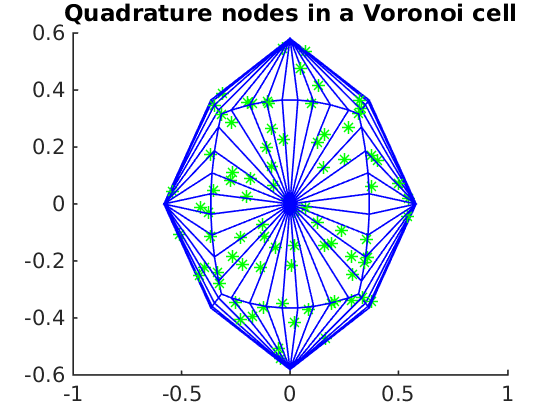

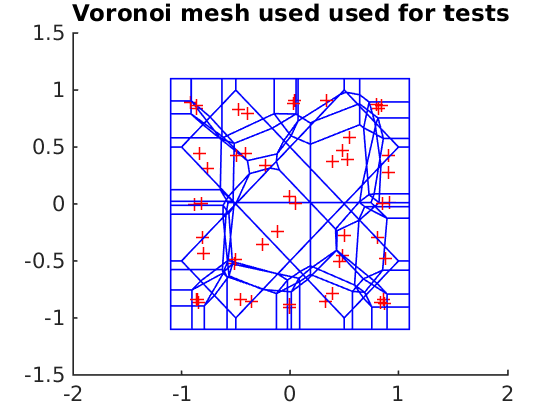

Computing volumes and centroids of the Voronoi mesh...
Elapsed time is 0.620848 seconds.

Comparison between chinIntegrate4Matlab and Voro++:
---------------------------------------------------
Relative inf norm of difference for volumes: 0.000000
Max relative euclidean norm of difference for centroid: 0.000000


Generating a quadrature formula of order 6 on a Voronoi cell...
Elapsed time is 60.546544 seconds.

Integrating x^6 + y^6 + z^6 + x^2*y^2*z^2 + x*y^5 using GiNaC...
Elapsed time is 0.645046 seconds.

Relative difference quadrature rule - GiNaC: 0.000000


In [14]:
addpath '../../VEM_diffusion/'
test_elements_features

Quadrature formulas on faces are generated using Gauss cubature over polygons based on Green's integration formula, see the paper by [Sommariva and Vianello](http://www.math.unipd.it/~marcov/pdf/gausscub.pdf).

## Local assemblers

In this paragraph, we will be describing how to assemble the local stiffness matrix and right hand side for each polyhedron. At present, only VEM spaces of degree $k = 1$ are supported.
In the code, the assemblage for a single element $E$ is performed by the function __VEM_ROOTDIR/VEM_diffusion_3d/local_assembler_3d_k1.m__. Before running local_assembler_3d_k1, few preliminary steps are required:

* Step 1: first, we have to read the connectivity information of $E$ from a mesh in OVM format. Let $Nfc(E)$ be the number of faces of $E$. Then, the goal is to represent $E$ as a $Nfc(E)\times1$ cell array, whose $f$-th entry is a row array with the vertices bounding face $f$ listed in counterclockwise order, i.e. according to the right hand rule applied to the outward normal of element $E$. This is done by the function __VEM_ROOTDIR/Mesh_Handlers/construct_element_connectivity.m__ using half faces and half edges stored in the OVM mesh. For each face $f = 1,\dots,Nfc(E)$, the function follows these steps:

    * Step i: read the corresponding half face $hf$ from $\verb|mesh.element2hfaces|$.
    * Step ii: check whether $hf$ has been stored in $\verb|mesh.face2hedges|$ or not by checking whether it is odd or even, respectively. If $hf$ is odd, go to Step iii. Otherwise, go to Step iv.
    * Step iii: read the list of half edges $he_1, \dots, he_N$ defining $hf$ in $\verb|mesh.face2hedges|$. For each half edge $he_i$, check whether $he_i$ has been stored in $\verb|mesh.edge2vertices|$ or not by checking whether it is odd or even. If $he_i$ is odd, go to Step iii-a. Otherwise, go to Step iii-b.
        * Step iii-a: read $he_i$ from $\verb|mesh.edge2vertices|$.
        * Step iii-b: apply the opp() operator to the twin odd half edge $he_i-1$ stored in $\verb|mesh.edge2vertices|$.
    * Step iv: apply the opp() operator to the twin half face $hf_\text{twin} = \{he'_1,\dots,he'_M\} = hf-1$ stored in $\verb|mesh.face2hedges|$. In particular

\begin{equation}
hf = opp(hf_\text{twin}) = \{opp(he'_M),\dots,opp(he'_1)\}.
\end{equation}

* Step 2: for each face $f = 1,\dots,Nfc(E)$, compute some relevant quantities:
    * $\verb|faces_bnd_nodes{f}|$: $x$ and $y$ coordinates of the boundary nodes of face $f$ with respect to the plane in which $f$ lies.
    * $\verb|faces_qformula2D{f}|$: quadrature nodes and weights for 2D quadrature formula on $f$.
    * $\verb|faces_normals(f,:)|$: 3D outward unit normal at face $f$.
    * $\verb|faces_algdist(f)|$: algebraic distance between the origin and the plane in which $f$ lies.
    * $\verb|faces_edges_normals2D{f}|$: 2D outward normal vectors for face f with respect to the plane in which $f$ lies.
    * $\verb|faces_diameters(f)|$: face diameter.
    * $\verb|faces_areas(f)|$: face area.
    * $\verb|faces_centroids2D(f,:)|$: $x$ and $y$ coordinates of the centroid of face $f$ with respect to the plane in which $f$ lies.
    * $\verb|collapsed variable(f)|$
    * $\verb|faces_orders(f)|$: number of nodes of face $f$.
    
In order to compute 2D quantities, we put ourselves in the plane in which $f$ lies by rotating $f$ so that its 3D outward unit normal is aligned either with the $x$ or the $z$ axis. Then, these quantities are computed using the 2D VEM code. Step 2 is performed by the function __VEM_ROOTDIR/Mesh_Handlers/faces_features.m__.

* Step 3: compute diameter, volume, centroid and 3D quadrature formula for element $E$. This is done by the function __VEM_ROOTDIR/Mesh_Handlers/elements_features.m__.
    

Once Steps 1-3 above have been performed, we can assemble the local stiffness matrix and right hand side with local_assembler_k1_3d.

## Convergence tests

### Computational domain

We take the domain to be the unit cube $\Omega = [0,1]\times[0,1]\times[0,1]$. We consider tetrahedral and hexahedral nested meshes (see Tables 1 and 2), as well as Voronoi meshes generated from random points (see Table 3).

$$\text{Table 1: Tetrahedral meshes of the domain $\Omega$ used in the convergence experiments.}$$
$$
\begin{array}{lllll}
\hline
 \text{Mesh name} & \text{Number of elements} & \text{Number of faces} & \text{Number of edges} & \text{Number of vertices}\\
 \hline
 \text{tetra}\_\text{Nelt000006} & 6      & 18     & 19     & 8 \\
 \text{tetra}\_\text{Nelt000048} & 48     & 120    & 98     & 27 \\
 \text{tetra}\_\text{Nelt000384} & 384    & 864    & 604    & 125 \\
 \text{tetra}\_\text{Nelt003072} & 3072   & 6528   & 4184   & 729 \\
 \text{tetra}\_\text{Nelt024576} & 24576  & 50688  & 31024  & 4913 \\
 \text{tetra}\_\text{Nelt196608} & 196608 & 399360 & 238688 & 35937 \\
 \hline
\end{array}
$$

$$\text{Table 2: Meshes of cubes of the domain $\Omega$ used in the convergence experiments.}$$
$$
\begin{array}{lllll}
\hline
 \text{Mesh name} & \text{Number of elements} & \text{Number of faces} & \text{Number of edges} & \text{Number of vertices}\\
\hline
 \text{cubes}\_\text{Nelt000008} & 8     & 36     & 54     & 27 \\
 \text{cubes}\_\text{Nelt000064} & 64    & 240    & 300    & 125 \\
 \text{cubes}\_\text{Nelt000512} & 512   & 1728   & 1944   & 729 \\
 \text{cubes}\_\text{Nelt004096} & 4096  & 13056  & 13872  & 4913 \\
 \text{cubes}\_\text{Nelt032768} & 32768 & 101376 & 104544 & 35937 \\
 \hline
\end{array}
$$

$$\text{Table 3: Voronoi meshes of the domain $\Omega$ used in the convergence experiments.}$$
$$
\begin{array}{lllll}
\hline
 \text{Mesh name} & \text{Number of elements} & \text{Number of faces} & \text{Number of edges} & \text{Number of vertices}\\
 \hline
 \text{unitcube}\_\text{voro}\_\text{Nelt8} & 8    & 47   & 80    & 42   \\
 \text{unitcube}\_\text{voro}\_\text{Nelt64} & 64   & 415  & 704   & 354  \\
 \text{unitcube}\_\text{voro}\_\text{Nelt512} & 512  & 3625 & 6228  & 3116  \\
 \text{unitcube}\_\text{voro}\_\text{Nelt4096} & 4096 & 30364 & 52538 & 26271 \\
\hline
\end{array}
$$

### First test


In the first convergence test, we take load term and Dirichlet boundary conditions so that the exact solution is:

\begin{equation}
u = \frac{1}{3\pi^2}\sin(\pi x)\sin(\pi y)\sin(\pi z).
\end{equation}

We test the Virtual Element Method for the polynomial degree $k = 1$ on all the meshes. Tables 4-6 show relative errors in the energy norm $e_S = \frac{||u-u_h||_S}{||u||_S}$, the inf norm $e_\infty = \frac{||u-u_h||_\infty}{||u||_\infty}$, and the $L^2$ norm $e_{L^2} = \frac{||u-u_h||_{L^2}}{||u||_{L^2}}$, and the estimated convergence rates (e.c.r.).

As expected, the relative errors $e_{L^2}$ on tetrahedral and hexahedral meshes exhibit $O(h^2)$ convergence rates, where $h$ is the maximum diameter of the elements of the mesh. On the other hand, care is needed when interpreting the convergence rates on the Voronoi meshes shown in Table 3 (see Table 6), due to the fact that these meshes are not nested.

Interestingly, on tetrahedral and hexahedral meshes, $e_S$ exhibits superconvergence $( O(h^2) )$. On the other hand, $e_S$ has the expected order of convergence $( O(h) )$ on Voronoi meshes. __TO DO: investigate whether there is a bug in the code__.

$$\text{Table 4: First convergence test on the tetrahedral meshes shown in Table 1.}$$
$$
\begin{array}{cccccc}
\hline
e_S & \text{e.c.r.} & e_\infty & \text{e.c.r.}  & e_{L^2} & \text{e.c.r.}\\
\hline
   \text{NaN}     & -    & 0      & -         & 0.0133 & -    \\
    0.4100 & \text{NaN}  & 0.4100 & -\infty   & 0.0085 & 0.65 \\
    0.1509 & 1.44 & 0.1434 & 1.52      & 0.0034 & 1.32 \\
    0.0444 & 1.76 & 0.0407 & 1.82      & 0.0010 & 1.77 \\
    0.0117 & 1.93 & 0.0106 & 1.95      & 0.0003 & 1.93 \\
    0.0030 & 1.98 & 0.0027 & 1.99      & 0.0001 & 1.98 \\
\hline
\end{array}
$$

$$\text{Table 5: First convergence test on the meshes of cubes shown in Table 2.}$$
$$
\begin{array}{cccccc}
\hline
e_S        & \text{e.c.r.} & e_\infty & \text{e.c.r.}  & e_{L^2} & \text{e.c.r.}\\
\hline
   0.5859  & -    & 0.5859 & -    & 0.0096 & -    \\
    0.2455 & 1.26 & 0.2454 & 1.26 & 0.0043 & 1.15 \\
    0.0756 & 1.70 & 0.0756 & 1.70 & 0.0013 & 1.69 \\
    0.0201 & 1.91 & 0.0201 & 1.91 & 0.0004 & 1.91 \\
    0.0051 & 1.98 & 0.0051 & 1.98 & 0.0001 & 1.98 \\
\hline
\end{array}
$$

$$\text{Table 6: First convergence test on the Voronoi meshes shown in Table 3.}$$
$$
\begin{array}{cccccc}
\hline
e_S & \text{e.c.r.}  & e_\infty & \text{e.c.r.}  & e_{L^2} & \text{e.c.r.}\\
\hline
   0.6034  & -    & 0.6791 & -    & 0.0113 & -    \\
    0.5911 & 0.03 & 0.4915 & 0.52 & 0.0063 & 0.93 \\
    0.2447 & 1.29 & 0.1581 & 1.66 & 0.0019 & 1.73 \\
    0.1262 & 1.03 & 0.0415 & 2.07 & 0.0005 & 2.00 \\
    \hline
\end{array}
$$

### Second test

In this test, we take load term and Dirichlet boundary conditions so that the exact solution has half the period of the first test:

\begin{equation}
u = \frac{1}{12\pi^2}\sin(2\pi x)\sin(2\pi y)\sin(2\pi z).
\end{equation}

We test the Virtual Element Method for the polynomial degree $k = 1$ on all the meshes. Tables 7-9 show relative errors $e_S, e_\infty$, and $e_{L^2}$, and the estimated convergence rates (e.c.r.).

As expected, errors are extremely high (or increasing) on the coarsest meshes since there are not enough vertices to correctly sample the oscillating behavior of the solution. As soon as sample points correctly catch the behavior of the solution, the relative errors $e_{L^2}$ on tetrahedral and hexahedral meshes exhibit $O(h^2)$ convergence rates. As before, care is needed when interpreting the convergence rates on the Voronoi meshes shown in Table 3 (see Table 9), due to the fact that these meshes are not nested.

Similarly to the previous test case, $e_S$ exhibits superconvergence $( O(h^2) )$ on tetrahedral and hexahedral meshes, but not on Voronoi meshes $( O(h) )$. __TO DO: investigate whether there is a bug in the code__.

$$\text{Table 7: Second convergence test on the tetrahedral meshes shown in Table 1.}$$
$$
\begin{array}{cccccc}
\hline
e_S & \text{e.c.r.} & e_\infty & \text{e.c.r.} & e_{L^2} & \text{e.c.r.}\\
\hline
       \text{NaN} & - & 0 & - & 0.0023 & - \\
    O(10^{17}) & \text{NaN} & O(10^{46}) & -\infty & 0.0032 & -0.47\\
    0.4317 & 156.37 & 0.4262 & 153.39 & 0.0021 & 0.59\\
    0.1688 & 1.35 & 0.1487 & 1.52 & 0.0009 & 1.28\\
    0.0501 & 1.75 & 0.0426 & 1.81 & 0.0003 & 1.73\\
    0.0132 & 1.93 & 0.0112 & 1.93 & 0.0001 & 1.92\\
\hline
\end{array}
$$

$$\text{Table 8: Second convergence test on the meshes of cubes shown in Table 2.}$$
$$
\begin{array}{cccccc}
\hline
e_S & \text{e.c.r.} & e_\infty & \text{e.c.r.} & e_{L^2} & \text{e.c.r.}\\
\hline
    O(10^{31}) & -      & O(10^{30}) & -      & 0.0031 & - \\
    0.5860     & 105.16 & 0.5897     & 102.15 & 0.0024 & 0.38\\
    0.2455     & 1.26   & 0.2461     & 1.26   & 0.0011 & 1.15\\
    0.0756     & 1.70   & 0.0757     & 1.70   & 0.0003 & 1.69\\
    0.0201     & 1.91   & 0.0201     & 1.91   & 0.0001 & 1.91\\
\hline
\end{array}
$$

$$\text{Table 9: Second convergence test on the Voronoi meshes shown in Table 3.}$$
$$
\begin{array}{cccccc}
\hline
e_S & \text{e.c.r.} & e_\infty & \text{e.c.r.} & e_{L^2} & \text{e.c.r.}\\
\hline
    0.9410     & -    & 0.9131 & -    & 0.0028 & -\\
    0.7245     & 0.42 & 0.7085 & 0.41 & 0.0025 & 0.18\\
    0.4816     & 0.60 & 0.4136 & 0.79 & 0.0013 & 0.92\\
    0.2569     & 0.97 & 0.1648 & 1.42 & 0.0005 & 1.56\\
\hline
\end{array}
$$